https://mlfromscratch.com/neural-network-tutorial/#/

fonctionne bien

In [1]:
from sklearn.datasets import fetch_openml
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
import time
import matplotlib.pyplot as plt
import pickle

In [2]:
(X_train, Y_train), (X_test, Y_test) = tf.keras.datasets.mnist.load_data()

y_train = tf.keras.utils.to_categorical(Y_train)
y_val = tf.keras.utils.to_categorical(Y_test)

x_train = X_train.reshape(len(X_train), 28*28)/255 # 28*28 = 784
x_val = X_test.reshape(len(X_test), 28*28)/255

In [3]:
x, y = fetch_openml('mnist_784', version=1, return_X_y=True)
x = (x/255).astype('float32')
y = tf.keras.utils.np_utils.to_categorical(y)

x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.15, random_state=42)

KeyboardInterrupt: 

In [5]:
class DeepNeuralNetwork():
    def __init__(self, sizes, epochs=10, l_rate=0.001):
        self.sizes = sizes
        self.epochs = epochs
        self.l_rate = l_rate

        # we save all parameters in the neural network in this dictionary
        self.params = self.initialization()

    def sigmoid(self, x, derivative=False):
        if derivative:
            return (np.exp(-x))/((np.exp(-x)+1)**2)
        return 1/(1 + np.exp(-x))

    def softmax(self, x, derivative=False):
        # Numerically stable with large exponentials
        exps = np.exp(x - x.max())
        if derivative:
            return exps / np.sum(exps, axis=0) * (1 - exps / np.sum(exps, axis=0))
        return exps / np.sum(exps, axis=0)

    def initialization(self):
        # number of nodes in each layer
        input_layer=self.sizes[0]
        hidden_1=self.sizes[1]
        hidden_2=self.sizes[2]
        output_layer=self.sizes[3]

        params = {
            'W1':np.random.randn(hidden_1, input_layer) * np.sqrt(1. / hidden_1),
            'W2':np.random.randn(hidden_2, hidden_1) * np.sqrt(1. / hidden_2),
            'W3':np.random.randn(output_layer, hidden_2) * np.sqrt(1. / output_layer)
        }

        return params

    def forward_pass(self, x_train):
        params = self.params

        # input layer activations becomes sample
        params['A0'] = x_train

        # input layer to hidden layer 1
        params['Z1'] = np.dot(params["W1"], params['A0'])
        params['A1'] = self.sigmoid(params['Z1'])

        # hidden layer 1 to hidden layer 2
        params['Z2'] = np.dot(params["W2"], params['A1'])
        params['A2'] = self.sigmoid(params['Z2'])

        # hidden layer 2 to output layer
        params['Z3'] = np.dot(params["W3"], params['A2'])
        params['A3'] = self.softmax(params['Z3'])

        return params['A3']

    def backward_pass(self, y_train, output):
        '''
            This is the backpropagation algorithm, for calculating the updates
            of the neural network's parameters.

            Note: There is a stability issue that causes warnings. This is 
                  caused  by the dot and multiply operations on the huge arrays.
                  
                  RuntimeWarning: invalid value encountered in true_divide
                  RuntimeWarning: overflow encountered in exp
                  RuntimeWarning: overflow encountered in square
        '''
        params = self.params
        change_w = {}

        # Calculate W3 update
        error = 2 * (output - y_train) / output.shape[0] * self.softmax(params['Z3'], derivative=True)
        change_w['W3'] = np.outer(error, params['A2'])

        # Calculate W2 update
        error = np.dot(params['W3'].T, error) * self.sigmoid(params['Z2'], derivative=True)
        change_w['W2'] = np.outer(error, params['A1'])

        # Calculate W1 update
        error = np.dot(params['W2'].T, error) * self.sigmoid(params['Z1'], derivative=True)
        change_w['W1'] = np.outer(error, params['A0'])

        return change_w

    def update_network_parameters(self, changes_to_w):
        '''
            Update network parameters according to update rule from
            Stochastic Gradient Descent.

            θ = θ - η * ∇J(x, y), 
                theta θ:            a network parameter (e.g. a weight w)
                eta η:              the learning rate
                gradient ∇J(x, y):  the gradient of the objective function,
                                    i.e. the change for a specific theta θ
        '''
        
        for key, value in changes_to_w.items():
            self.params[key] -= self.l_rate * value

    def compute_accuracy(self, x_val, y_val):
        '''
            This function does a forward pass of x, then checks if the indices
            of the maximum value in the output equals the indices in the label
            y. Then it sums over each prediction and calculates the accuracy.
        '''
        predictions = []

        for x, y in zip(x_val, y_val):
            output = self.forward_pass(x)
            pred = np.argmax(output)
            predictions.append(pred == np.argmax(y))
        
        return np.mean(predictions)

    def train(self, x_train, y_train, x_val, y_val):
        start_time = time.time()
        for iteration in range(self.epochs):
            for x,y in zip(x_train, y_train):
                output = self.forward_pass(x)
                changes_to_w = self.backward_pass(y, output)
                self.update_network_parameters(changes_to_w)
            
            accuracy = self.compute_accuracy(x_val, y_val)
            print('Epoch: {0}, Time Spent: {1:.2f}s, Accuracy: {2:.2f}%'.format(
                iteration+1, time.time() - start_time, accuracy * 100
            ))
            

In [39]:
dnn = DeepNeuralNetwork(sizes=[784, 10, 10, 10])

In [40]:
dnn.train(x_train, y_train, x_val, y_val)

Epoch: 1, Time Spent: 8.54s, Accuracy: 11.42%
Epoch: 2, Time Spent: 17.28s, Accuracy: 11.90%
Epoch: 3, Time Spent: 25.97s, Accuracy: 12.80%
Epoch: 4, Time Spent: 34.49s, Accuracy: 13.25%
Epoch: 5, Time Spent: 42.98s, Accuracy: 13.59%
Epoch: 6, Time Spent: 51.49s, Accuracy: 13.91%
Epoch: 7, Time Spent: 60.02s, Accuracy: 13.95%
Epoch: 8, Time Spent: 68.73s, Accuracy: 14.72%
Epoch: 9, Time Spent: 77.32s, Accuracy: 16.59%
Epoch: 10, Time Spent: 85.94s, Accuracy: 17.76%


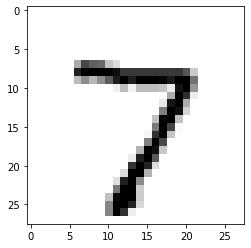

In [37]:
plt.imshow(x_val[0].reshape((28, 28)), cmap="binary")

Predicted 0 : [0.51654213 0.01779608 0.09885377 0.12699985 0.03506811 0.02329013
 0.06283657 0.02128665 0.05627245 0.04105426]


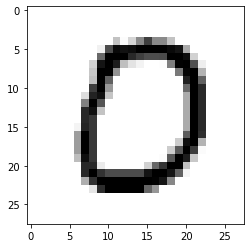

In [19]:
i = 10
y = dnn.forward_pass(x_val[i])
plt.imshow(x_val[i].reshape((28, 28)), cmap="binary")
print(f"Predicted {np.argmax(y)} : {y}")

In [7]:
dnn.compute_accuracy(x_val, y_val)

0.5441

In [38]:
dnn1 = dnn

In [41]:
import pickle
pickle.dump( dnn, open( "dnn_mnist_scratch.p", "wb" ) )

In [6]:
dnn = pickle.load( open( "dnn_mnist_scratch.p", "rb" ) )

In [45]:
dnn.params["W1"].shape

(128, 784)